In [8]:
from rl_ood import *
path = Path.cwd()

# OOD environments instantiation

In [9]:
default_values = CARTPOLE_VALUES
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

Each ood config differs from the defaut environment by only one attribute.

In [43]:
values = create_ood_values(default_values)
ood_configs = get_ood_configs(default_values, values)
len(ood_configs)


50

In [11]:
ood_configs[0]

{'Gravity': 0.30625,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0,
 'change': 'Gravity'}

# Evaluate OOD impact

### Original environment

We train an agent on the original environment, and we evaluate its performances

In [12]:
env = instanciate_cartpole(default_values)

path_agent = path / 'Agents' / 'trained_CartPole'
#if os.path.exists(path_agent):
#    agent = A2C.load(path_agent)
#else:
try:
    agent = A2C.load(path_agent, env=env)
except:
    agent = A2C('MlpPolicy', env)
    agent.learn(10000)
    agent.save(path_agent)

evaluate(env, agent, nb_episodes=10, render=True)

(162.0, 14.352700094407323)

We evaluate this agent on several ood environments. We get the mean and std of the reward over 10 episodes.

In [13]:
ood_env = instanciate_cartpole(ood_configs[0])
agent = A2C.load(path_agent, env=ood_env)
evaluate(ood_env, agent, render=False)

(721.459, 58.271796943289814)

In [14]:
ood_env = instanciate_cartpole(ood_configs[-1])
evaluate(ood_env, agent, render=False)

(4.764, 4.453347504967471)

In [17]:
#print("number of ood values per attribute:", len(values['Gravity']))

### Impact of the ood on the reward

In [18]:
default_values, values = get_cartpole_values()
results = {}
std_results = {}

original_env = instanciate_cartpole(default_values)
agent = A2C.load(path_agent, env=original_env)
original_result, original_std_result = evaluate(original_env, agent, render=False)

for config in tqdm(ood_configs):
    if config['change'] not in results:
        results[config['change']] = []
        std_results[config['change']] = []
    
    ood_env = instanciate_cartpole(config)
    agent = A2C.load(path_agent, env=ood_env)
    mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=100)
    
    results[config['change']].append(mean_reward)
    std_results[config['change']].append(std_reward)
    #print(config, mean_reward)
    



100%|██████████| 50/50 [05:08<00:00,  6.17s/it]


In [25]:
width

array([3.33333333e-01, 6.66666667e-01, 1.33333333e+00, 2.66666667e+00,
       5.33333333e+00, 1.06666667e+01, 2.13333333e+01, 4.26666667e+01,
       8.53333333e+01, 1.70666667e+02, 3.41333333e+02])

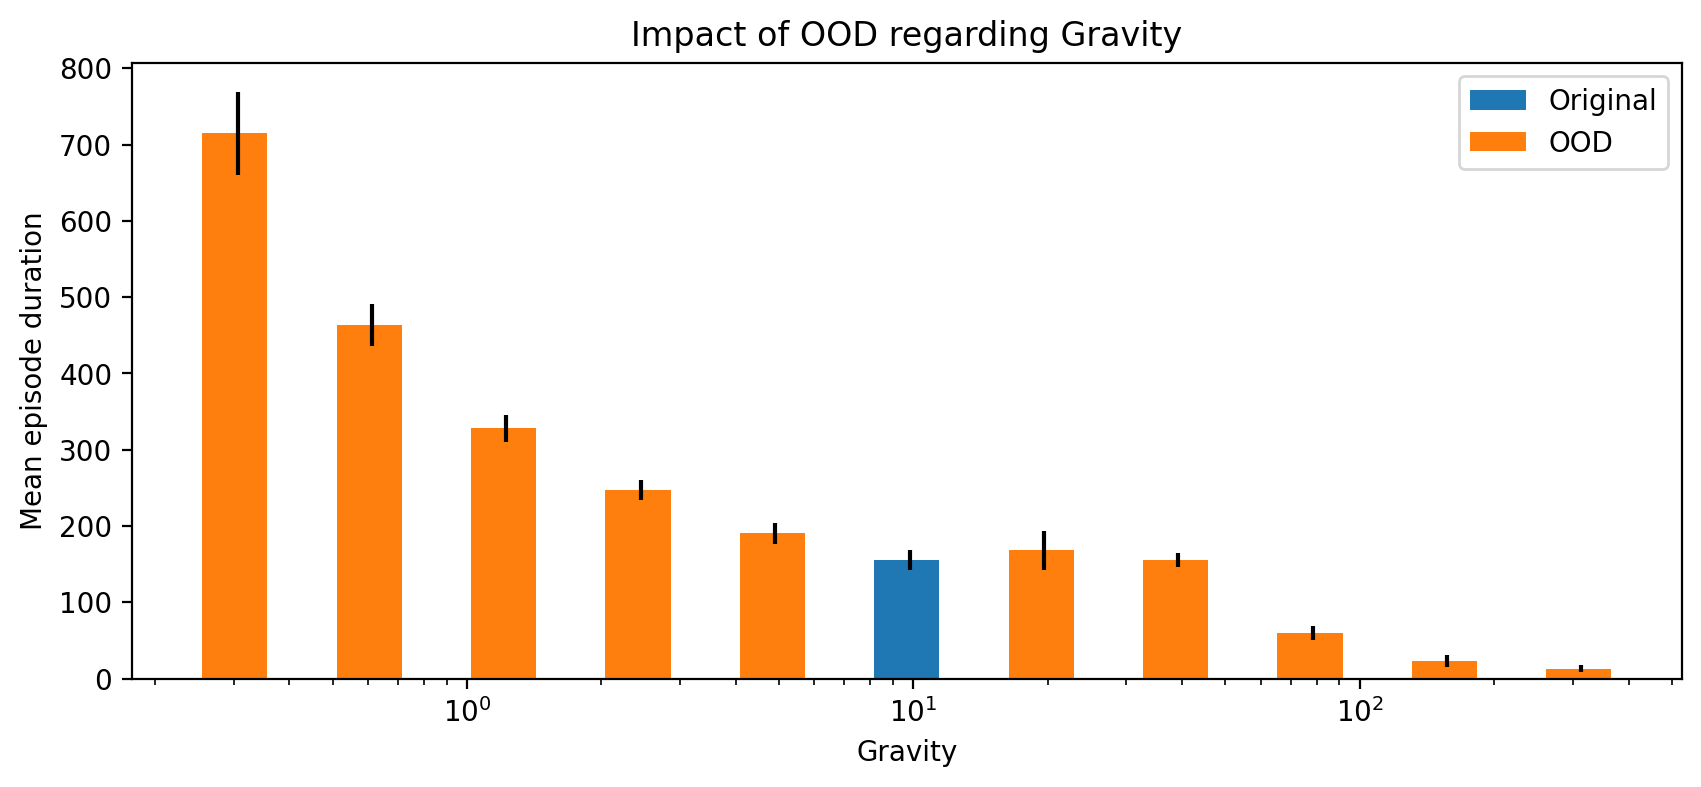

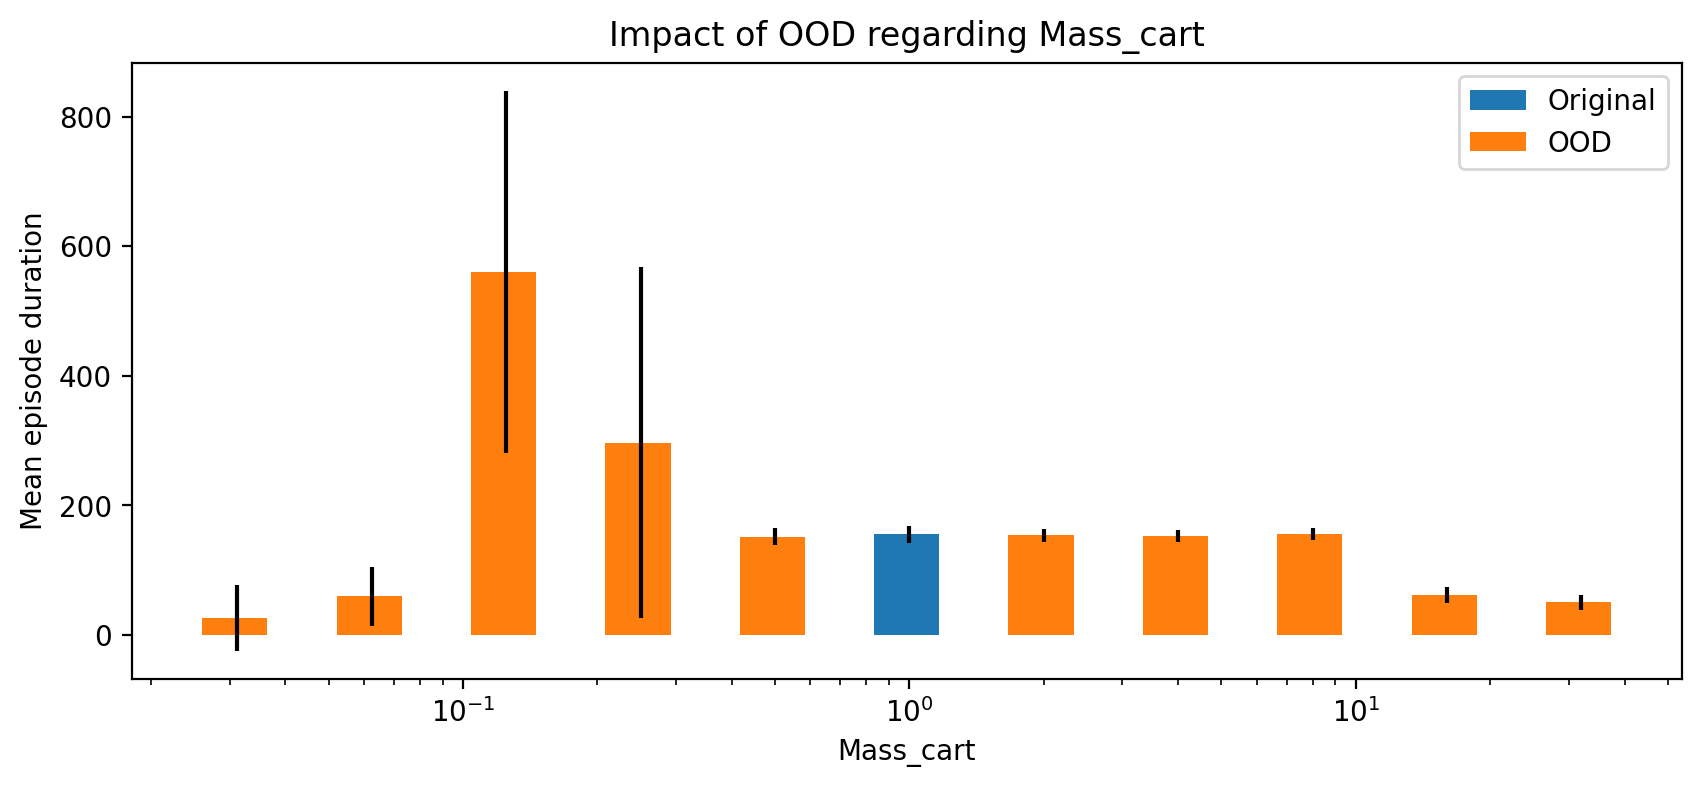

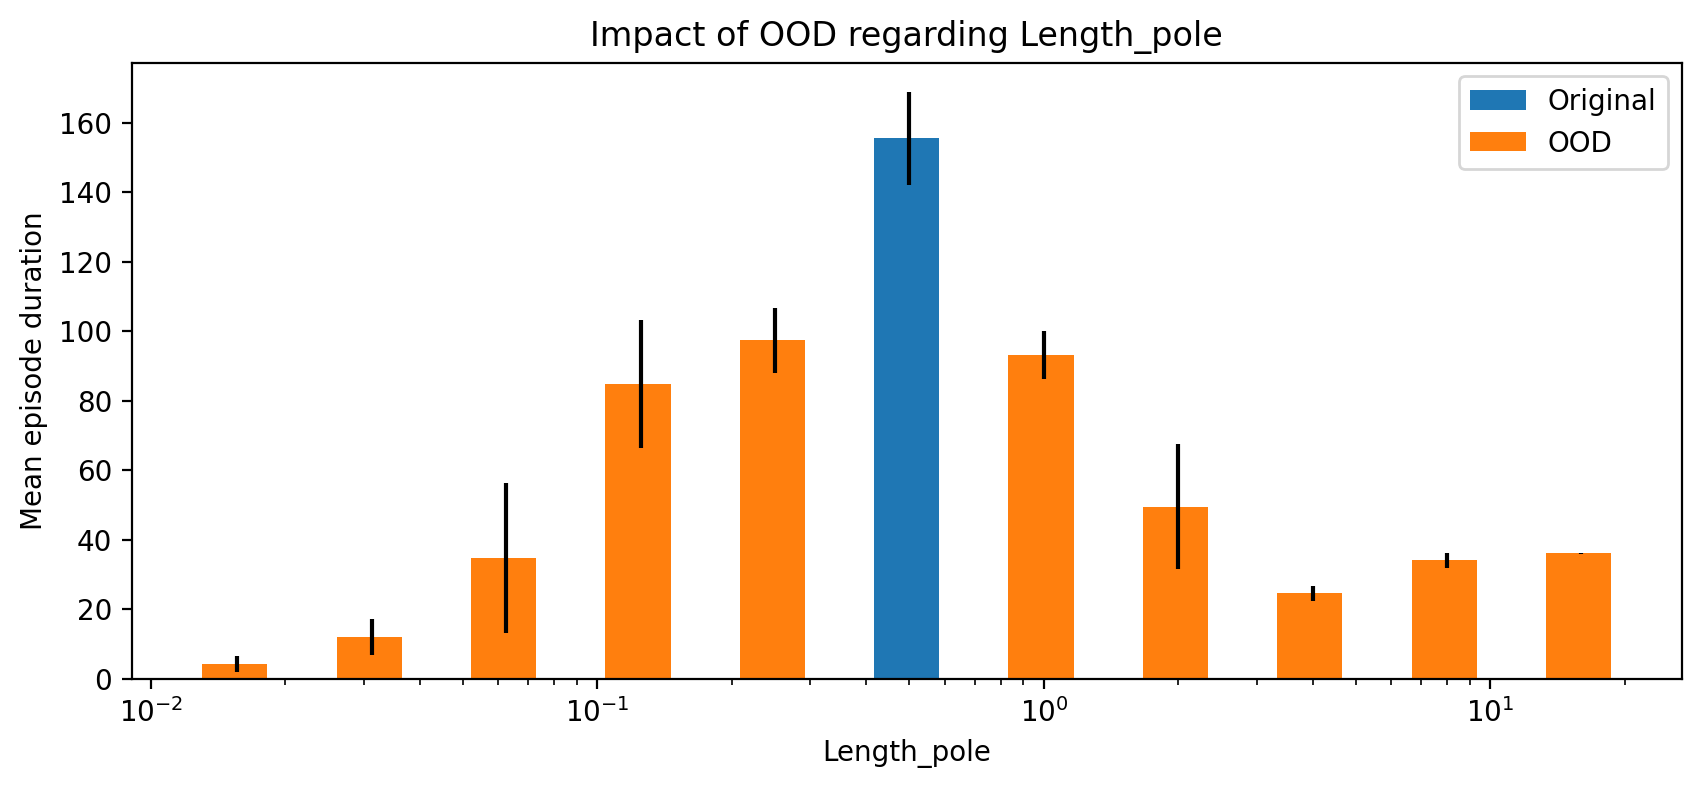

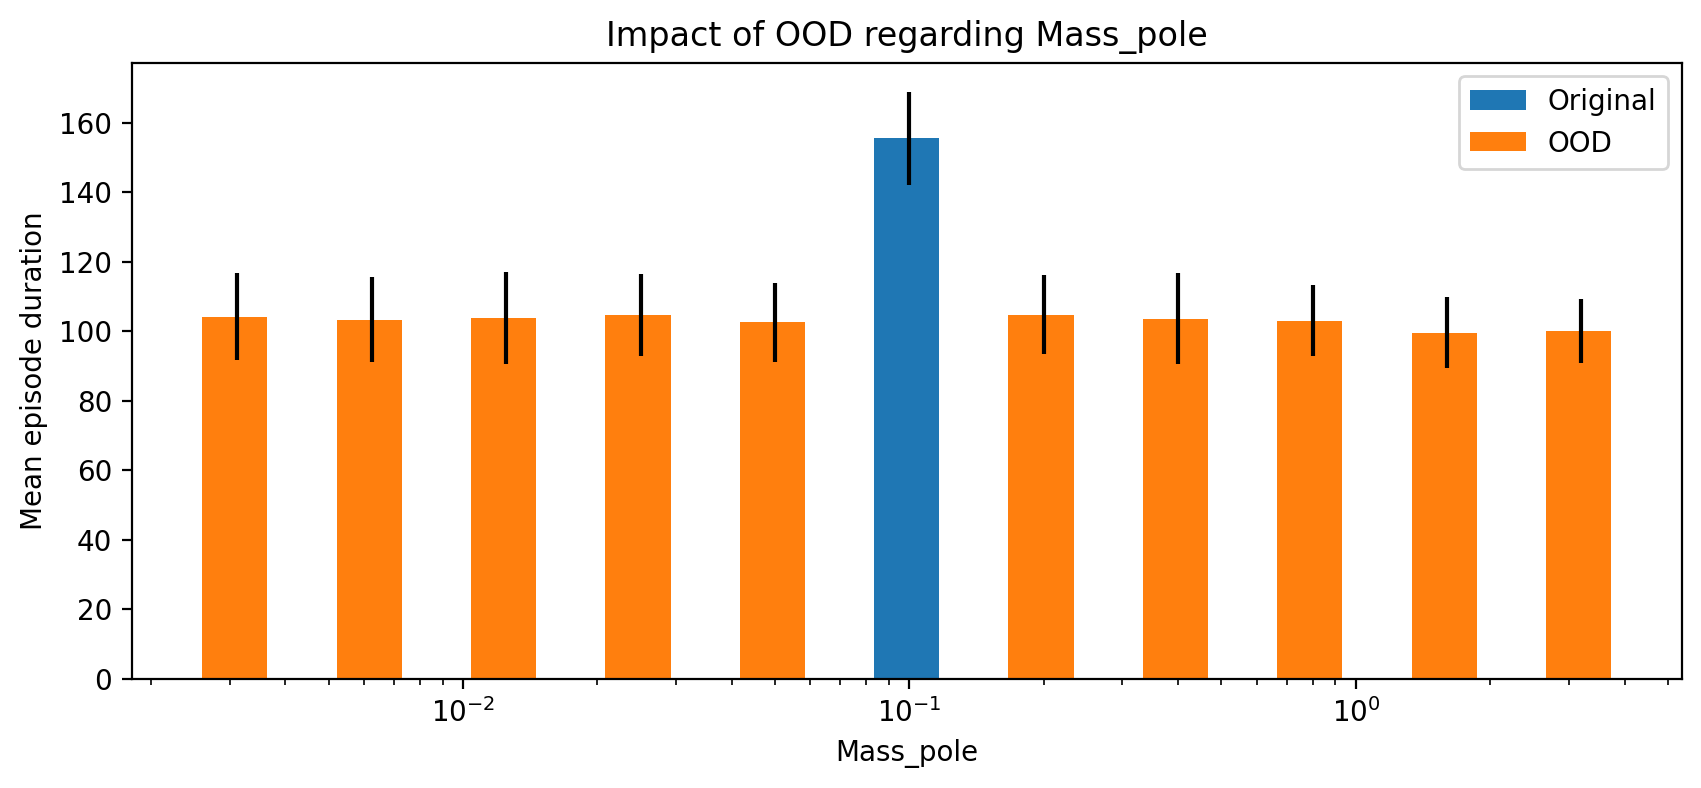

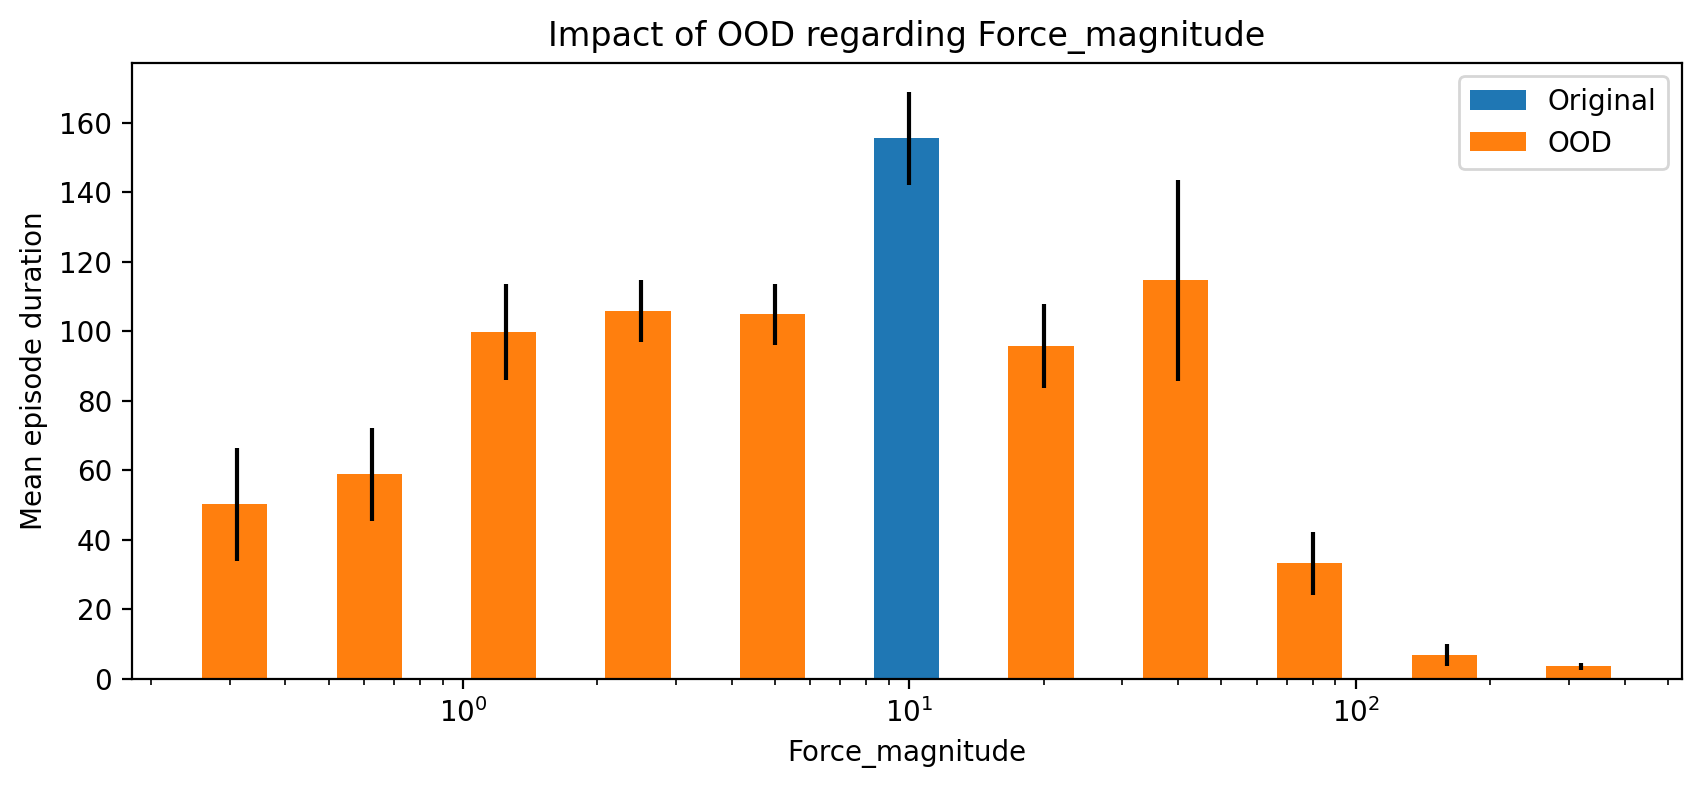

In [33]:
for key in results:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    width = np.array([2**i for i in range(-5, 0)] + [2**i for i in range(1, 5+1)]) #np.array(labels[1:]) - np.array(labels[:-1]) 
    width *= default_values[key]/3.0
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)
    ax.bar(default_values[key], original_result, yerr=original_std_result, width=default_values[key]/3.0, label='Original')
    ax.bar(values[key], results[key], yerr=std_results[key], width=width, label='OOD')
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)
    ax.legend()
    """
    ax.bar(str(default_values[key]), original_result, width=width)
    labels = [str(x) for x in values[key]]
    ax.bar(labels, results[key], width=width)
    """
    

# Create OOD detector

The configuration ood detector is relative to its default environment

In [35]:
default_values, values = get_cartpole_values()
env = instanciate_cartpole(default_values)
ood_detector = MartingaleOODDetector(env, verbose=False)
default_values

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 10.0}

We have a low ood score on the delaut environment

In [36]:
ood_detector.get_in_distrib_score()

0.25255328469390564

It should be higher on ood environment

In [37]:
ood_config = get_ood_configs(default_values, values)[-1]
ood_env = instanciate_cartpole(ood_config)
ood_config

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 100.0,
 'change': 'Force_magnitude'}

In [38]:
ood_score = ood_detector.test_ood(ood_env, nb_steps=100)
ood_score

9556.387488624363

Let's compute the ood scores of the previously studies ood environments

In [39]:
default_values, values = get_cartpole_values()
mean_ood_scores = {}
std_ood_scores = {}

original_env = instanciate_cartpole(default_values)
agent = A2C.load(path_agent, env=original_env)
ood_detector = MartingaleOODDetector(env)
in_distrib_score = ood_detector.get_in_distrib_score()

for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_scores:
        mean_ood_scores[config['change']] = []
        std_ood_scores[config['change']] = []
    
    ood_env = instanciate_cartpole(config)
    agent = A2C.load(path_agent, env=ood_env)
    list_scores = np.array([ood_detector.test_ood(ood_env, nb_steps=100) for _ in range(10)])
    ood_score = list_scores.mean()
    std_score = list_scores.std()

    #mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=10)

    mean_ood_scores[config['change']].append(ood_score)
    std_ood_scores[config['change']].append(std_score)
    #print(config, mean_reward)
    



 20%|██        | 10/50 [00:06<00:26,  1.51it/s]/Users/gardille/opt/anaconda3/envs/accenta/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/gardille/opt/anaconda3/envs/accenta/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/gardille/opt/anaconda3/envs/accenta/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/gardille/opt/anaconda3/envs/accenta/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/gardille/opt/anaconda3/envs/accenta/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: ove

We now realise a plot of the mean reward and ood scores of each environment. The ones of the delaut environment are in darker colour at the middle of the plot.

In [72]:
mean_ood_scores

{'Gravity': array([0.29615416, 0.25281055, 0.25275242, 0.2529615 , 0.25260183,
        0.2527529 , 0.25393843, 0.25759834, 0.26748039, 0.29615416]),
 'Mass_cart': array([2.16343330e+04, 2.16343330e+04, 4.11644715e+00, 3.88169728e-01,
        2.80282250e-01, 2.60674297e-01, 2.68261775e-01, 2.72337939e-01,
        2.74607921e-01, 2.75455750e-01]),
 'Length_pole': array([3.27896975e+04, 3.27896975e+04, 1.34851398e+00, 3.34143715e-01,
        2.69095894e-01, 2.57365267e-01, 2.61280872e-01, 2.63426034e-01,
        2.64185757e-01, 2.64756559e-01]),
 'Mass_pole': array([0.2597314 , 0.25330456, 0.25312257, 0.25261732, 0.25289258,
        0.25252683, 0.25308627, 0.25396401, 0.25591346, 0.2597314 ]),
 'Force_magnitude': array([           inf, 2.74789271e-01, 2.71834386e-01, 2.68573747e-01,
        2.61048240e-01, 2.82452619e-01, 4.18177159e-01, 1.10655944e+03,
                   inf,            inf])}

In [71]:
mean_ood_scores['Gravity'] > 1.1

array([False, False, False, False, False, False, False, False, False,
       False])

In [69]:
{std_ood_scores[k] > 1.1 for k in std_ood_scores}

TypeError: unhashable type: 'numpy.ndarray'

In [67]:
{std_ood_scores[k][6] for k in std_ood_scores}

{0.00031479609900338465,
 0.0005004237886920752,
 0.000597189387932269,
 0.000643041546657753,
 0.0030921198967216674}

100%|██████████| 5/5 [00:00<00:00, 34.17it/s]


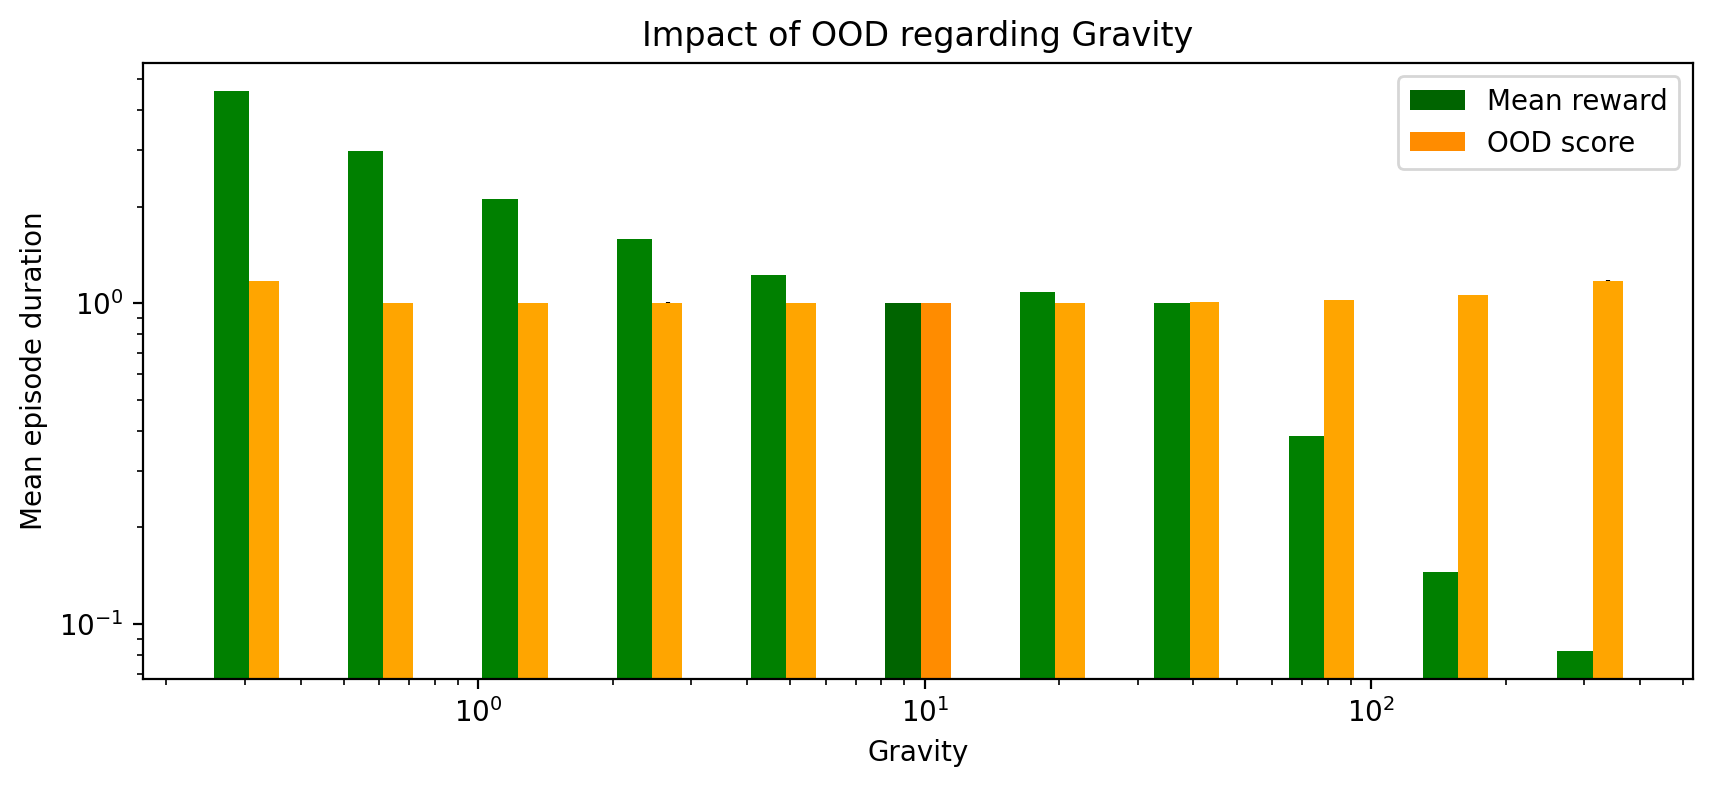

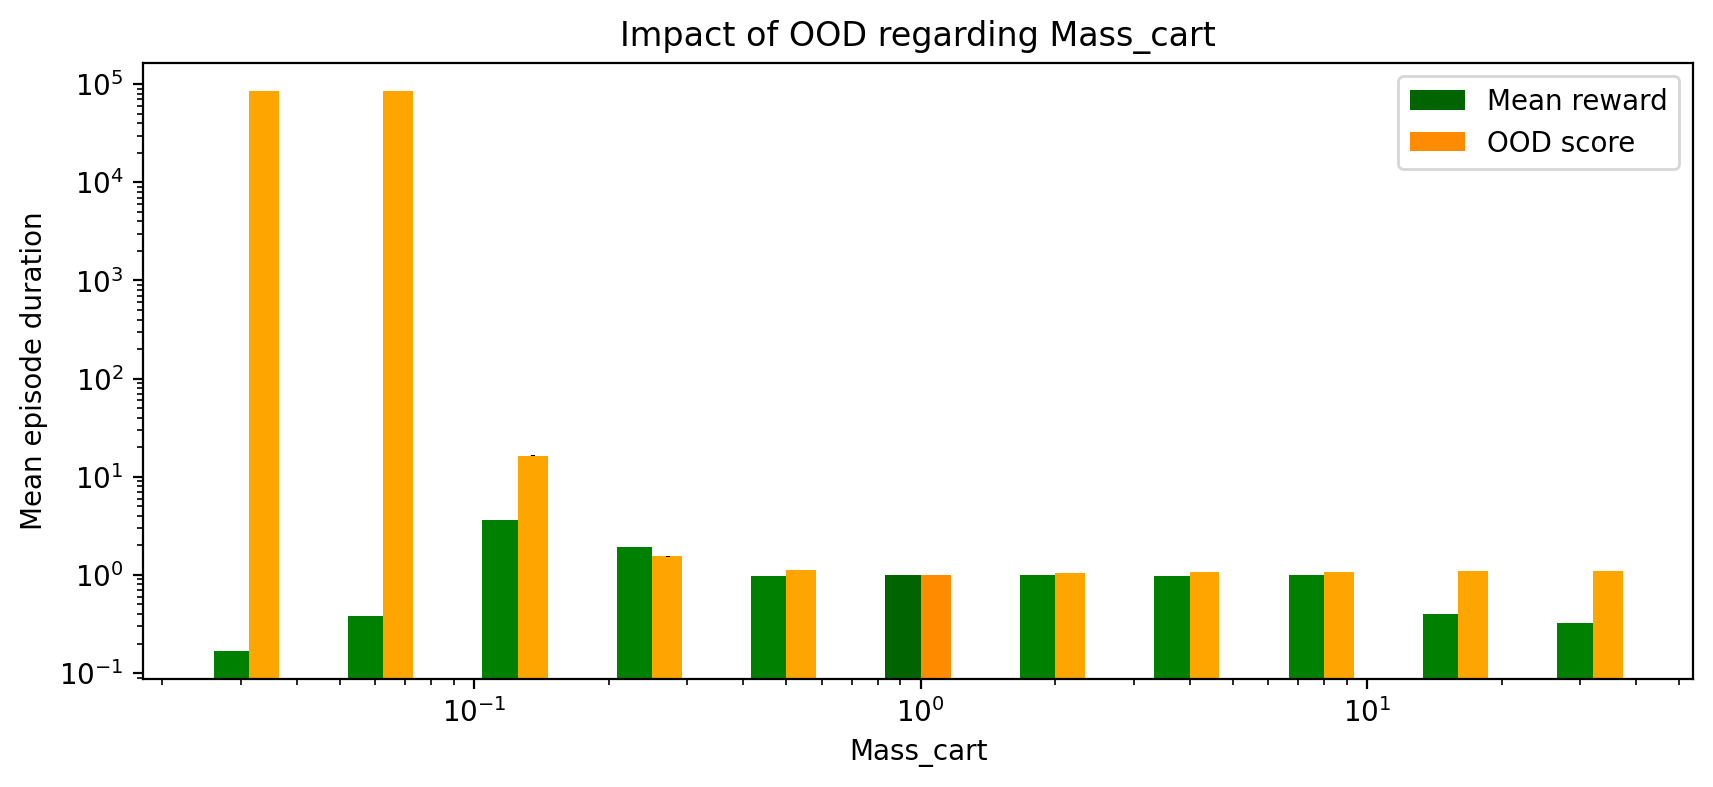

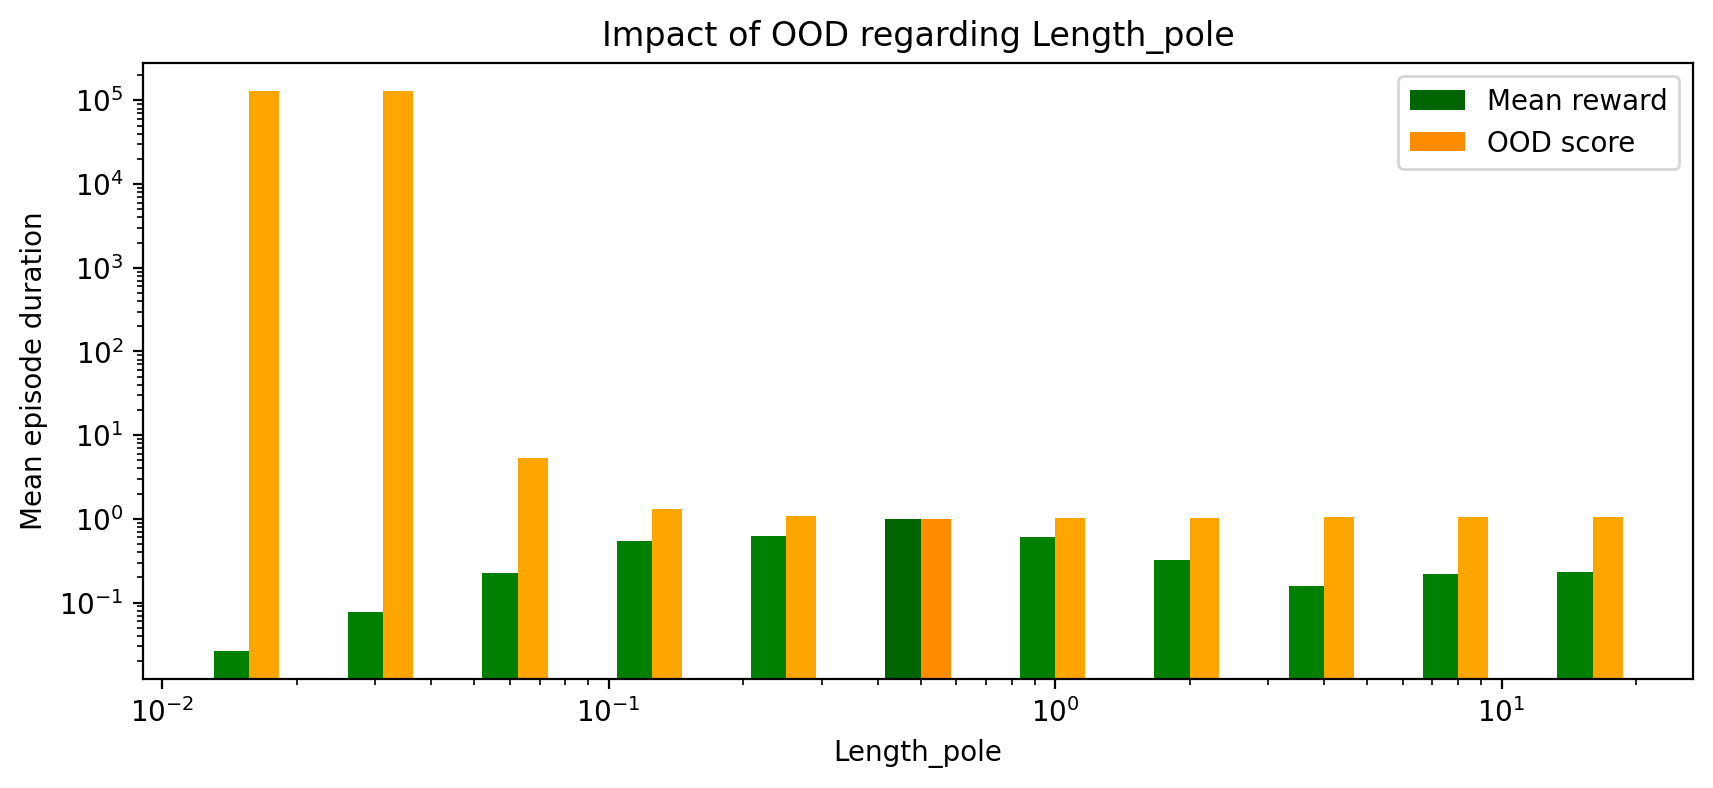

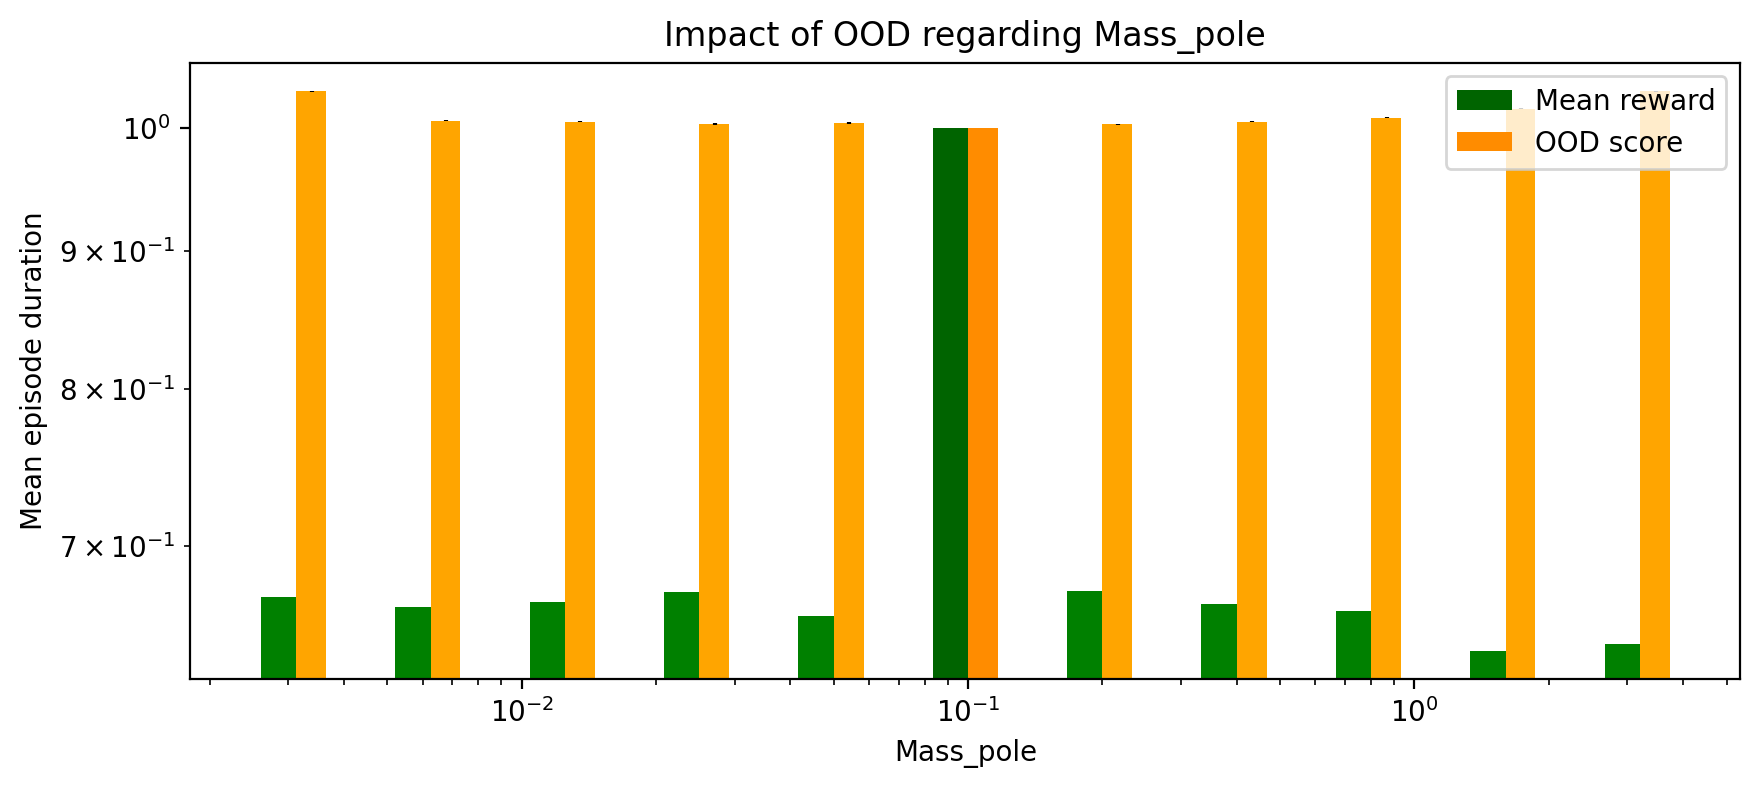

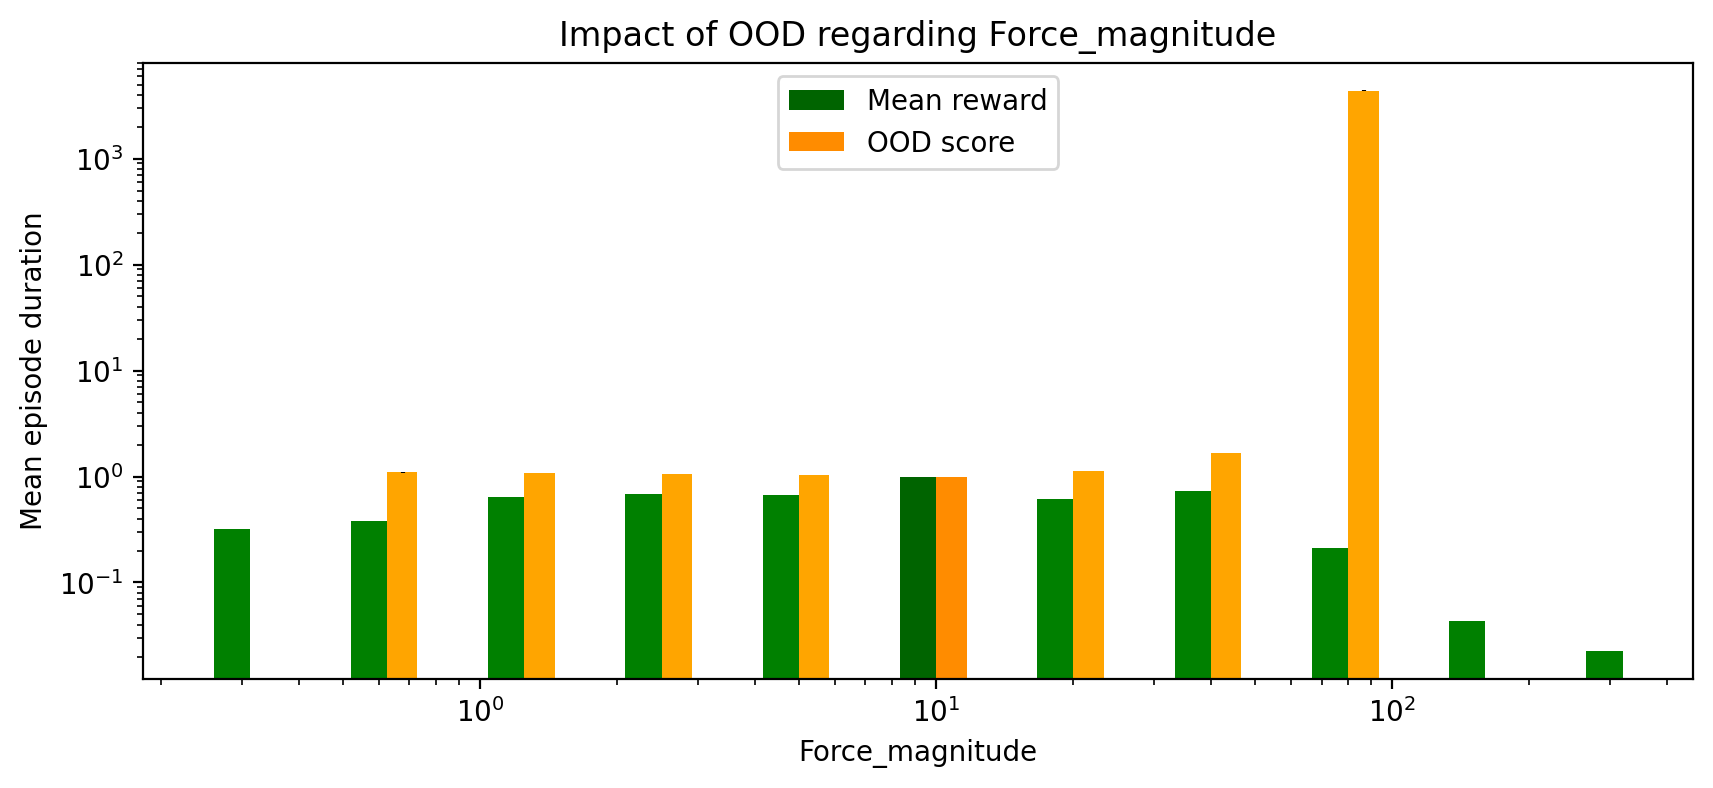

In [66]:
from turtle import color
from numpy import inf


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    #mean_ood_scores[key] = np.nan_to_num(mean_ood_scores[key], copy=True, nan=0.0, posinf=max(mean_ood_scores[key]), neginf=0)
    #std_ood_scores[key] = np.nan_to_num(std_ood_scores[key], copy=True, nan=0.0, posinf=max(std_ood_scores[key]), neginf=0)

    default_width = default_values[key]/6.0
    width = np.array([2**i for i in range(-5, 0)] + [2**i for i in range(1, 5+1)]) #np.array(labels[1:]) - np.array(labels[:-1]) 
    width *= default_width
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)

    ax.bar(default_values[key]- default_width/2, 1.0, width=default_width, label='Mean reward', color='darkgreen')
    ax.bar(values[key]- width/2, results[key]/original_result, width=width,  color='green')

    ax.bar(default_values[key]+default_width/2, 1.0, width=default_width, label='OOD score', color='darkorange')
    ax.bar(values[key]+ width/2, mean_ood_scores[key]/in_distrib_score, width=width, color='orange', yerr=std_ood_scores[key])
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)
   

We add as maning in distribution examples and there are ood examples

In [ ]:
original_env = instanciate_cartpole(default_values)
agent = A2C.load(path_agent, env=original_env)

list_scores = []
for _ in trange(5*18):
    list_scores.append(np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(10)]).mean())

mean_ood_scores['None'] = list_scores

100%|██████████| 90/90 [00:11<00:00,  7.64it/s]


# Detection speed at a fixed threshold

In [74]:
std_ood_scores['Gravity']

(10,)

In [136]:
original_env = instanciate_cartpole(default_values)
list_scores = np.array([ood_detector.test_ood(original_env, nb_steps=1000) for _ in range(100)])
ood_score = list_scores.mean()
std_score = list_scores.std()

ood_score, std_score, threshold

(0.2537496091431509, 0.0002789667850397592, 0.26003814487060356)

In [97]:
from rl_ood import *

In [137]:
threshold = ood_score + 10*std_score

In [138]:
np.array([ood_detector.test_ood(original_env, nb_steps=100) for _ in range(100)]) > threshold

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [146]:
X_val[:20].shape

(20, 50)

In [147]:

class MartingaleOODDetector():
    def __init__(self, env: gym.Env, verbose=False, *args, **kwargs) -> None:

        self.verbose = verbose

        # training the model
        X_pred, y_pred = create_dataset(env, nb_steps=10000)
        self.pred_model = MultiOutputRegressor(KNeighborsRegressor()).fit(X_pred, y_pred)
        #self.conf_model = conf_model

        self.in_distrib_score = self.test_ood(env)

        if self.verbose:
            print("Anomaly score of the training distribution: ", self.in_distrib_score)

    def get_in_distrib_score(self):
        return self.in_distrib_score

    def test_ood(self, env, nb_steps=1000):
        """
        Compute the ood score
        """
        X_val, y_val = create_dataset(env, nb_steps)
        errors = np.abs((self.pred_model.predict(X_val) - y_val))

        if self.verbose:
            print("Absolute error")
            print("Mean: ", errors.mean())
            print("Std: ", errors.std())
            print()


        # Calibration of the ood detector
        pre_ood_score = martingale(compute_p_values(errors))   
        ood_score = nb_steps * np.log(1 + pre_ood_score) #/nb_steps
        #print("corrected score ", np.log10(ood_score)/nb_steps)
        return ood_score

    def stop_above_threshold(self, env, threshold, start_at=50, nb_steps=1000):
        """
        Compute the number of step for the ood score to go above the threshold
        """
        X_val, y_val = create_dataset(env, nb_steps)

        for step in range(start_at,nb_steps):
            errors = np.abs((self.pred_model.predict(X_val[:step]) - y_val[:step]))

            if self.verbose:
                print("Absolute error")
                print("Mean: ", errors.mean())
                print("Std: ", errors.std())
                print()


            # Calibration of the ood detector
            pre_ood_score = martingale(compute_p_values(errors))   
            ood_score = step * np.log(1 + pre_ood_score) #/nb_steps
            #print("corrected score ", np.log10(ood_score)/nb_steps)
            if ood_score > threshold:
                return step, ood_score
        return nb_steps, ood_score

    def save(self, path):
        np.save(path / 'nonconformity_scores.npy', self.nonconformity_scores)
        
    def load(self, path):
        self.nonconformity_scores = np.load(path / 'nonconformity_scores.npy')



ood_detector = MartingaleOODDetector(original_env)

In [135]:
Y = [ood_detector.test_ood(original_env, nb_steps=n) for n in range(1,1000)]
plt.plot(Y)

[0.18234814963645352,
 0.21074419948087655,
 0.22239952707508043,
 0.22881010187195291,
 0.2327197647749708,
 0.23544200031178825,
 0.23740923231698335,
 0.23898516687762675,
 0.24022205206942757,
 0.24216285691886158,
 0.2420790360405346,
 0.24278944633043692,
 0.24407579796167253,
 0.2460308332884792,
 0.24752601864585846,
 0.24782058338752586,
 0.24785909649862353,
 0.2463168820818801,
 0.2481083521740514,
 0.24988492199178272,
 0.24833431885765142,
 0.24906417399853742,
 0.24868575909082682,
 0.2519995417994756,
 0.24881427564691816,
 0.251382583544969,
 0.250200846963436,
 0.2494515058950575,
 0.2518475434276627,
 0.249911429049118,
 0.2512810998058205,
 0.2483262002354998,
 0.2506079592613445,
 0.24967950897698526,
 0.24959260790428553,
 0.2502559019736461,
 0.2503930040473992,
 0.2506571353220464,
 0.25033478622219696,
 0.24990881143498067,
 0.25038105583229325,
 0.24970911901619658,
 0.2520179203196517,
 0.25102735487477384,
 0.25105559196279653,
 0.25084902179939517,
 0.252450

In [141]:
threshold

0.2565392769935485

In [148]:
ood_detector.stop_above_threshold(original_env, threshold, start_at=50, nb_steps=100)

(100, 0.2531019083551234)

In [150]:
ood_detector.stop_above_threshold(original_env, threshold, start_at=50, nb_steps=1000)

(1000, 0.25373587474163994)

In [151]:
default_values, values = get_cartpole_values()
mean_ood_stops = {}
std_ood_stops = {}

original_env = instanciate_cartpole(default_values)
agent = A2C.load(path_agent, env=original_env)
ood_detector = MartingaleOODDetector(env)


for config in tqdm(ood_configs):
    if config['change'] not in mean_ood_stops:
        mean_ood_stops[config['change']] = []
        mean_ood_stops[config['change']] = []
    
    ood_env = instanciate_cartpole(config)
    agent = A2C.load(path_agent, env=ood_env)
    list_stops = np.array([ood_detector.stop_above_threshold(original_env, threshold, start_at=30, nb_steps=1000)[0] for _ in range(10)])
    mean_ood_stop = list_stops.mean()
    std_ood_stop = list_stops.std()

    #mean_reward, std_reward = evaluate(ood_env, agent, nb_episodes=10)

    mean_ood_stops[config['change']].append(mean_ood_stop)
    std_ood_stops[config['change']].append(std_ood_stop)
    #print(config, mean_reward)
    



  0%|          | 0/50 [21:26<?, ?it/s]


KeyError: 'Gravity'

In [ ]:
from turtle import color
from numpy import inf


for key in tqdm(results):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    labels = copy(values[key])
    labels.append(default_values[key])
    labels = sorted(labels)
    
    #mean_ood_scores[key] = np.nan_to_num(mean_ood_scores[key], copy=True, nan=0.0, posinf=max(mean_ood_scores[key]), neginf=0)
    #std_ood_scores[key] = np.nan_to_num(std_ood_scores[key], copy=True, nan=0.0, posinf=max(std_ood_scores[key]), neginf=0)

    default_width = default_values[key]/6.0
    width = np.array([2**i for i in range(-5, 0)] + [2**i for i in range(1, 5+1)]) #np.array(labels[1:]) - np.array(labels[:-1]) 
    width *= default_width
    #print(width, np.array([width[-1]]))
    #width = np.concatenate((width, np.array([width[-1]])))/ 5
    #print(width)

    ax.bar(default_values[key]- default_width/2, 1.0, width=default_width, label='Mean stop', color='darkgreen')
    ax.bar(values[key]- width/2, results[key], width=width,  color='green')

    ax.bar(default_values[key]+default_width/2, 1000.0, width=default_width, label='OOD stop', color='darkorange')
    ax.bar(values[key]+ width/2, mean_ood_stops[key], width=width, color='orange', yerr=std_ood_scores[key])
    
    ax.set_xlabel(key)
    ax.set_ylabel('Mean episode duration')
    ax.set_title('Impact of OOD regarding '+key)

    plt.legend() #prop={'size': 'medium'}, ncol=2)
   

# Computation of the AUC score

In [ ]:
def compute_AUC(mean_ood_scores, plot=True, verbose=False):
    TPRs = []
    FPRs = []

    thresholds = [10**(-i/10) for i in range(-50, 50+1)]
    for threshold in thresholds:
        false_pos=0
        false_neg=0
        true_pos=0
        true_neg=0

        for key in mean_ood_scores:
            if str(key) != 'None': # Env OOD
                for test_res in mean_ood_scores[key]:

                    if test_res<threshold: # Not detected as OOD
                        false_neg +=1
                    else:
                        true_pos +=1
            else: # Env standard
                for test_res in mean_ood_scores[key]:

                    if test_res>threshold: # Detected as OOD
                        false_pos +=1
                    else:
                        true_neg +=1


        try:
            tpr = true_pos/(true_pos+false_neg)
        except ZeroDivisionError:
            print('error computing tpr')
            continue
            tpr = 1.0
        
        try:
            fpr = false_pos/(false_pos+true_neg)
        except ZeroDivisionError:
            print('error computing fpr')
            continue

        if verbose:
            print(threshold)
            print('TP', true_pos, 'FP',false_pos)
            print('FN', false_neg, 'TN',true_neg)
            print()
            print(tpr, fpr)
        TPRs.append(tpr)
        FPRs.append(fpr)
        #AUC += tpr/len(thresholds)

    if verbose:
        plt.title("TPR and FPR curves")
        plt.plot(TPRs, label='TPR')
        plt.plot(FPRs, label='FPR')
        plt.legend()
        plt.show()
        
    #print('AUC: ', AUC)
    plt.title("ROC curve")
    plt.plot(FPRs, TPRs,'-*')
    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.show()

    AUC = integrate.simps(x=FPRs, y=TPRs, even='avg')
    return AUC

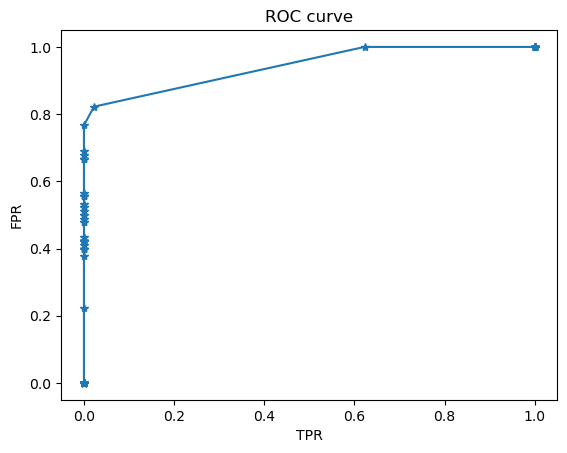

0.9436793171772595

In [ ]:
compute_AUC(mean_ood_scores)